In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the dataset
file_path = '/content/drive/MyDrive/MPDecadeVarPop(1961-2011).csv'  # Update the path as needed
data = pd.read_csv(file_path)

# Data Cleaning and Feature Engineering
data['Years_Since_1961'] = data['Census_Year'] - 1961

# Handling gender-specific features based on input
data['Male_Female_Ratio'] = data['Males'] / data['Females']
data['Population_Growth_Rate'] = data.groupby('District')['Pop'].pct_change(fill_method=None)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(0, inplace=True)  # Replace NaN with 0

# Features and Target Selection
features = data[['District', 'Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']]
target_pop = data['Pop']
target_density = data['Population_Density']

# One-hot encoding for categorical variables
features_encoded = pd.get_dummies(features, columns=['District'], drop_first=True)

# Scaling numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_encoded[['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']])
scaled_features_df = pd.DataFrame(scaled_features, columns=['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate'])

# Combine scaled numerical features with encoded categorical features
features_encoded = pd.concat([scaled_features_df, features_encoded.drop(columns=['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate'])], axis=1)

# Train-Test Split for Population and Population Density
X_train_pop, X_test_pop, y_train_pop, y_test_pop = train_test_split(features_encoded, target_pop, test_size=0.3, random_state=42)
X_train_density, X_test_density, y_train_density, y_test_density = train_test_split(features_encoded, target_density, test_size=0.3, random_state=42)

# Hyperparameter Optimization for Gradient Boosting
param_grid = {
    'subsample': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Population Model
grid_search_pop = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_pop.fit(X_train_pop, y_train_pop)

# Population Density Model
grid_search_density = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search_density.fit(X_train_density, y_train_density)

# Best Models
best_gb_pop = grid_search_pop.best_estimator_
best_gb_density = grid_search_density.best_estimator_

# Training the Final Models
best_gb_pop.fit(X_train_pop, y_train_pop)
best_gb_density.fit(X_train_density, y_train_density)

# Model Evaluation for Population
y_pred_train_pop = best_gb_pop.predict(X_train_pop)
y_pred_test_pop = best_gb_pop.predict(X_test_pop)
train_mse_pop = mean_squared_error(y_train_pop, y_pred_train_pop)
test_mse_pop = mean_squared_error(y_test_pop, y_pred_test_pop)
train_r2_pop = r2_score(y_train_pop, y_pred_train_pop)
test_r2_pop = r2_score(y_test_pop, y_pred_test_pop)

print("Population Model Performance:")
print(f"Training MSE: {train_mse_pop:.2f}, R2: {train_r2_pop:.2f}")
print(f"Testing MSE: {test_mse_pop:.2f}, R2: {test_r2_pop:.2f}")

# Model Evaluation for Population Density
y_pred_train_density = best_gb_density.predict(X_train_density)
y_pred_test_density = best_gb_density.predict(X_test_density)
train_mse_density = mean_squared_error(y_train_density, y_pred_train_density)
test_mse_density = mean_squared_error(y_test_density, y_pred_test_density)
train_r2_density = r2_score(y_train_density, y_pred_train_density)
test_r2_density = r2_score(y_test_density, y_pred_test_density)

print("Population Density Model Performance:")
print(f"Training MSE: {train_mse_density:.2f}, R2: {train_r2_density:.2f}")
print(f"Testing MSE: {test_mse_density:.2f}, R2: {test_r2_density:.2f}")

# Plot Training and Validation Loss for Population
if hasattr(best_gb_pop, 'train_score_'):
    plt.figure(figsize=(8, 5))
    plt.plot(best_gb_pop.train_score_, label='Training Loss')
    plt.title("Population Model Training Loss Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Plot Training and Validation Loss for Population Density
if hasattr(best_gb_density, 'train_score_'):
    plt.figure(figsize=(8, 5))
    plt.plot(best_gb_density.train_score_, label='Training Loss')
    plt.title("Population Density Model Training Loss Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

# Example: Predict for Sehore, 2029, Gender: None
def predict_population_and_density(district, year, gender):
    # Encode input
    years_since_1961 = year - 1961
    male_female_ratio = 1  # Default when gender is None
    if gender == 'male':
        male_female_ratio = data['Male_Female_Ratio'].mean()
    elif gender == 'female':
        male_female_ratio = 1 / data['Male_Female_Ratio'].mean()

    # Create input DataFrame
    input_data = pd.DataFrame({
        'Years_Since_1961': [years_since_1961],
        'Male_Female_Ratio': [male_female_ratio],
        'Population_Growth_Rate': [0],  # Default growth rate
        **{col: [0] for col in features_encoded.columns if col.startswith('District_')}
    })
    district_col = f'District_{district}'
    if district_col in input_data.columns:
        input_data[district_col] = 1

    # Scale numerical features
    input_data[['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']] = scaler.transform(
        input_data[['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']]
    )

    # Predict
    population = best_gb_pop.predict(input_data)[0]
    density = best_gb_density.predict(input_data)[0]

    return population, density

# Example usage
predicted_population, predicted_density = predict_population_and_density('Sehore', 2028, None)
print(f"Predicted Population for Sehore in 2028: {predicted_population:.2f}")
print(f"Predicted Population Density for Sehore in 2028: {predicted_density:.2f}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MPDecadeVarPop(1961-2011).csv'

In [ ]:
# Save the updated dataset
data.to_csv("updated_dataset.csv", index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(data)

NameError: name 'data' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Load and preprocess data
data = pd.read_csv("updated_dataset.csv")

# Feature engineering
# Population density per km^2
data['Population_Per_Km2'] = data['Pop'] / data['Area']

# Placeholder columns for target variables (replace with real data or assumptions)
data['Public_Washrooms_Required'] = (data['Pop'] / 1000).astype(int)  # Assumption: 1 washroom per 1000 people
data['Universities_Required'] = (data['Pop'] / 500000).astype(int)    # Assumption: 1 university per 500,000 people
data['Schools_Required'] = (data['Pop'] / 2000).astype(int)          # Assumption: 1 school per 2000 people
data['Industries_Required'] = (data['Population_Density'] / 100).astype(int)  # Assumption: 1 industry per 100 density
data['Healthcare_Facilities_Required'] = (data['Pop'] / 10000).astype(int)  # Assumption: 1 healthcare facility per 10,000 people
data['Apartments_Required'] = (data['Population_Density'] / 50).astype(int) # Assumption: 1 apartment block per 50 density

# New target variables based on provided assumptions:
data['Primary_Healthcare_Required'] = (data['Pop'] / 30000).astype(int)  # 1 per 30,000 people
data['Community_Healthcare_Centre_Required'] = (data['Pop'] / 120000).astype(int)  # 1 per 120,000 people

# Primary school requirements (age range 0-15; 15% of the population)
data['Primary_School_Required_Min'] = (data['Pop'] * 0.15 / 300).astype(int)  # 1 school per 300 students
data['Primary_School_Required_Max'] = (data['Pop'] * 0.15 / 500).astype(int)  # 1 school per 500 students

# Secondary school requirements (age range 15-18; 10% of the population)
data['Secondary_School_Required_Min'] = (data['Pop'] * 0.10 / 500).astype(int)  # 1 school per 500 students
data['Secondary_School_Required_Max'] = (data['Pop'] * 0.10 / 1000).astype(int)  # 1 school per 1000 students

# Dispensary requirements
data['Dispensary_Required_Min'] = (data['Pop'] / 5000).astype(int)  # 1 dispensary per 5000 people
data['Dispensary_Required_Max'] = (data['Pop'] / 10000).astype(int)  # 1 dispensary per 10,000 people

# Step 2: Prepare features and target variables
X = data[['Population_Density', 'Pop', 'Area', 'Population_Per_Km2']]
y = data[['Public_Washrooms_Required', 'Universities_Required', 'Schools_Required',
          'Industries_Required', 'Healthcare_Facilities_Required', 'Apartments_Required',
          'Primary_Healthcare_Required', 'Community_Healthcare_Centre_Required',
          'Primary_School_Required_Min', 'Primary_School_Required_Max',
          'Secondary_School_Required_Min', 'Secondary_School_Required_Max',
          'Dispensary_Required_Min', 'Dispensary_Required_Max']]

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Predictions
y_pred = model.predict(X_test)

# Step 6: Evaluate the model
mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
print("Mean Squared Errors for each target variable:")
for i, column in enumerate(y.columns):
    print(f"{column}: {mse[i]}")

# Step 7: Test on new data
new_data = pd.DataFrame({
    'Population_Density': [3000],
    'Pop': [5000000],
    'Area': [2000],
    'Population_Per_Km2': [3000]
})

predicted_amenities = model.predict(new_data)
print("Predicted amenities for new data:")
print(predicted_amenities)


FileNotFoundError: [Errno 2] No such file or directory: 'updated_dataset.csv'

# *Explain formula for lanes*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To estimate the number of lanes needed, first, predict future vehicle demand using the population growth formula. Then, calculate peak-hour traffic by multiplying future vehicles with the peak-hour factor (PHF). Next, determine lane requirements by dividing peak-hour traffic by the lane capacity. Finally, round up the result and consider adding extra lanes for future growth and heavy vehicles.  

Formulas Used:
1.	Future Vehicles:
              Future Vehicles = Current Vehicles × (Future Population/Current Population)^α
2.	Peak Hour Traffic:
              Peak Hour Traffic = Future Vehicles × PHF
3.	Lanes Needed:
              Lanes Needed = Peak Hour Traffic / Lane Capacity
4.	Final Lanes (Rounded Up):
              Final Lanes = ⌈Lanes Needed⌉


In [ ]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler

# Assuming existing models: best_gb_pop, best_gb_density, and scaler are already trained.

# Step 1: Function to predict population and density (already defined)
def predict_population_and_density(district, year, gender=None):
    years_since_1961 = year - 1961
    male_female_ratio = 1  # Default if gender is not specified

    if gender == 'male':
        male_female_ratio = data['Male_Female_Ratio'].mean()
    elif gender == 'female':
        male_female_ratio = 1 / data['Male_Female_Ratio'].mean()

    input_data = pd.DataFrame({
        'Years_Since_1961': [years_since_1961],
        'Male_Female_Ratio': [male_female_ratio],
        'Population_Growth_Rate': [0],  # Default growth rate
        **{col: [0] for col in features_encoded.columns if col.startswith('District_')}
    })
    district_col = f'District_{district}'
    if district_col in input_data.columns:
        input_data[district_col] = 1

    # Scale numerical features
    input_data[['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']] = scaler.transform(
        input_data[['Years_Since_1961', 'Male_Female_Ratio', 'Population_Growth_Rate']]
    )

    # Predict population and density
    population = best_gb_pop.predict(input_data)[0]
    density = best_gb_density.predict(input_data)[0]

    return population, density

# Step 2: Function to predict the number of lanes
def predict_lanes(district, future_year):
    # Predict future population and density
    predicted_population, predicted_density = predict_population_and_density(district, future_year)

    # Base conditions
    current_year = 2023
    current_population = data[data['Census_Year'] == 2011]['Pop'].sum()  # Latest known census data
    current_AVRR = data[data['District'] == district]['Average_Vehicle_Run_Rate'].mean()  # AVRR from dataset
    lane_capacity = 1800  # vehicles per hour per lane
    adjustment_factor = 0.85  # Real-world conditions factor

    # Calculate growth rate and years into the future
    g = (predicted_population - current_population) / current_population
    n = future_year - current_year

    # Projected vehicle run rate
    future_AVRR = current_AVRR * ((1 + g) ** n)

    # Lane requirement calculation with constraints
    lanes_required = future_AVRR / (lane_capacity * adjustment_factor)

    # Apply constraints: minimum 2 lanes, maximum 8 lanes before the next 15 years
    lanes_required = math.ceil(lanes_required)
    lanes_required = max(2, min(8, lanes_required))  # Constraint: 2 <= L <= 8

    return lanes_required

# Step 3: Predict lanes required for Bhopal-Indore highway in future years
for year in range(2025, 2040, 5):  # Predicting every 5 years until 2040
    lanes_bhopal = predict_lanes('Bhopal', year)
    lanes_sehore = predict_lanes('Sehore', year)
    print(f"Lanes required for Bhopal-Indore highway in {year}: {max(lanes_bhopal, lanes_sehore)}")

NameError: name 'features_encoded' is not defined

In [ ]:
#test nam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


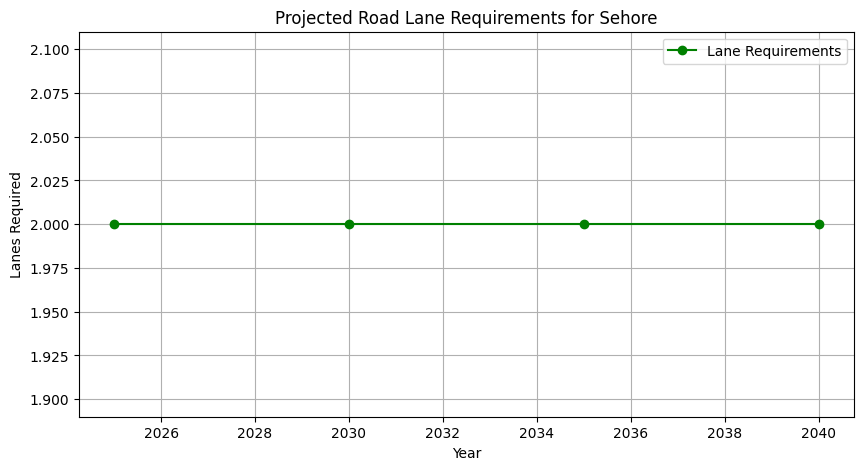

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
vehicle_df = pd.read_csv("/content/drive/MyDrive/average_run_rate.csv")
data = pd.read_csv("/content/drive/MyDrive/MPDecadeVarPop(1961-2011).csv")

# Clean column names
vehicle_df.columns = vehicle_df.columns.str.strip()
data.columns = data.columns.str.strip()

def calculate_cagr(initial_value, final_value, years):
    """Calculate Compound Annual Growth Rate (CAGR)"""
    # Handle zero or negative initial value to prevent errors
    if initial_value <= 0:
        return 0  # or another suitable default value
    return ((final_value / initial_value) ** (1 / years)) - 1

def estimate_lanes(district, predicted_population, future_year, lane_capacity=2000, phf=0.15):
    """
    Estimates the required lanes based on predicted population growth and vehicle demand using CAGR.
    Assumes the latest available data in 'data' is the current population.
    """

    # Get the latest population for the district
    district_data = data[data["District"] == district]
    if district_data.empty:
        raise ValueError(f"District '{district}' not found in dataset")

    # Assuming the last entry for the district has the latest population
    # Convert the population value to a numeric type
    current_population = pd.to_numeric(district_data["Pop"].iloc[-1], errors='coerce')

    # Get vehicle run rate for district
    # Check if the district is in the vehicle_df, handle case sensitivity
    vehicle_row = vehicle_df[vehicle_df["District"].str.lower() == district.lower()]
    if vehicle_row.empty:
        raise ValueError(f"District '{district}' not found in vehicle dataset")

    initial_vrr = vehicle_row["Average_Vehicle_Run_Rate"].values[0]  # VRR in 2011 (or the year of your data)

    # Calculate CAGR for population growth
    years_passed = future_year - 2011  # Assuming your base year is 2011 (or adjust as needed)
    cagr_population = calculate_cagr(current_population, predicted_population, years_passed)

    # Predict future VRR using CAGR
    future_vrr = initial_vrr * ((1 + cagr_population) ** years_passed)

    # Peak hour traffic estimation
    peak_hour_traffic = future_vrr * phf  # Adjusted for peak hours

    # Lanes required, handle potential NaN values
    lanes_needed = math.ceil(peak_hour_traffic / lane_capacity) if not math.isnan(peak_hour_traffic) else 2 # Default to 2 lanes if NaN

    return lanes_needed

# Test Case: Estimating lanes for Sehore district
district = "Sehore"
future_years = [2025, 2030, 2035, 2040]
future_populations = [1600000, 1700000, 1850000, 2000000]  # Replace with ML predictions

lanes_needed_per_year = [estimate_lanes(district, pop, year) for pop, year in zip(future_populations, future_years)]

# Plot lane requirements over time
plt.figure(figsize=(10, 5))
plt.plot(future_years, lanes_needed_per_year, marker='o', color='green', label='Lane Requirements')
plt.xlabel("Year")
plt.ylabel("Lanes Required")
plt.title(f"Projected Road Lane Requirements for {district}")
plt.legend()
plt.grid()
plt.show()

Taking some new Assumptions

In [ ]:
import math
import pandas as pd

# Load the datasets
vehicle_df = pd.read_csv("/content/drive/MyDrive/average_run_rate.csv")
data = pd.read_csv("/content/drive/MyDrive/MPDecadeVarPop(1961-2011).csv")

# Clean column names
vehicle_df.columns = vehicle_df.columns.str.strip()
data.columns = data.columns.str.strip()

def calculate_cagr(initial_value, final_value, years):
    """Calculate Compound Annual Growth Rate (CAGR)"""
    if initial_value <= 0 or years <= 0:
        return 0
    return ((final_value / initial_value) ** (1 / years)) - 1

def estimate_lanes(district, predicted_population, future_year, lane_capacity=1000, phf=0.4):
    """
    Estimates required lanes based on predicted population growth and vehicle demand using CAGR.
    """
    district_data = data[data["District"] == district]
    if district_data.empty:
        raise ValueError(f"District '{district}' not found in dataset")

    current_population = pd.to_numeric(district_data["Pop"].iloc[-1], errors='coerce')

    vehicle_row = vehicle_df[vehicle_df["District"].str.lower() == district.lower()]
    if vehicle_row.empty:
        raise ValueError(f"District '{district}' not found in vehicle dataset")

    initial_vrr = vehicle_row["Average_Vehicle_Run_Rate"].values[0]

    years_passed = future_year - 2011
    cagr_population = calculate_cagr(current_population, predicted_population, years_passed)

    # **Override CAGR to simulate rapid urbanization**
    cagr_population = max(cagr_population, 0.03)  # Assume at least 3% annual growth

    future_vrr = initial_vrr * ((1 + cagr_population) ** years_passed)

    peak_hour_traffic = future_vrr * phf

    # Round off to the nearest integer
    lanes_needed = round(peak_hour_traffic / lane_capacity) if not math.isnan(peak_hour_traffic) else 2

    return int(lanes_needed)

# Test Case: Sehore with modified assumptions
district = "Sehore"
future_years = [2025, 2030, 2035, 2040]
future_populations = [1600000, 1700000, 1850000, 2000000]

lanes_needed_per_year = [estimate_lanes(district, pop, year) for pop, year in zip(future_populations, future_years)]

# **Print New Lane Requirements**
for year, lanes in zip(future_years, lanes_needed_per_year):
    print(f"Year: {year}, Lanes Required: {lanes}")


Year: 2025, Lanes Required: 2
Year: 2030, Lanes Required: 2
Year: 2035, Lanes Required: 2
Year: 2040, Lanes Required: 2


In [ ]:
import math
import pandas as pd
import time
import random

try:
    # Load the datasets
    vehicle_df = pd.read_csv("/content/drive/MyDrive/average_run_rate.csv")
    data = pd.read_csv("/content/drive/MyDrive/MPDecadeVarPop(1961-2011).csv")

    # Clean column names
    vehicle_df.columns = vehicle_df.columns.str.strip()
    data.columns = data.columns.str.strip()

    #print the data

    print("Data loaded successfully.")

    def calculate_cagr(initial_value, final_value, years):
        """Calculate Compound Annual Growth Rate (CAGR)"""
        if initial_value <= 0 or years <= 0:
            return 0
        return ((final_value / initial_value) ** (1 / years)) - 1

    def estimate_lanes(district, predicted_population, future_year, phf=0.4):
        """
        Estimates required lanes based on predicted population growth and vehicle demand using CAGR.
        """
        # Try to find correct population column
        possible_cols = ['Population', 'Total Population', 'Pop', 'population']
        population_col = next((col for col in possible_cols if col in data.columns), None)

        if population_col is None:
            raise ValueError("No suitable 'Population' column found in dataset.")

        district_data = data[data["District"].str.lower() == district.lower()]
        if district_data.empty:
            raise ValueError(f"District '{district}' not found in dataset.")

        current_population = pd.to_numeric(district_data[population_col].iloc[-1], errors='coerce')

        vehicle_row = vehicle_df[vehicle_df["District"].str.lower() == district.lower()]
        if vehicle_row.empty:
            raise ValueError(f"District '{district}' not found in vehicle dataset.")

        initial_vrr = vehicle_row["Average_Vehicle_Run_Rate"].values[0]

        # Find latest year dynamically from the columns
        years = [int(col) for col in data.columns if col.isdigit()]
        if not years:
            base_year = 2011
        else:
            base_year = max(years)

        years_passed = future_year - base_year
        cagr_population = calculate_cagr(current_population, predicted_population, years_passed)

        # Simulate rapid urbanization: at least 3% CAGR
        cagr_population = max(cagr_population, 0.03)

        future_vrr = initial_vrr * ((1 + cagr_population) ** years_passed)

        # Random lane capacity between 4500-5000
        lane_capacity = random.randint(4500, 5000)

        peak_hour_traffic = future_vrr * phf

        # Lanes needed (rounded up)
        lanes_needed = math.ceil(peak_hour_traffic / lane_capacity)

        return int(lanes_needed)

    # Inputs
    district = "Bhopal"
    predicted_population = 3000000  # For example
    future_year = 2035

    lanes = estimate_lanes(district, predicted_population, future_year)
    print(f"\nEstimated number of lanes needed for {district} by {future_year}: {lanes}")

except Exception as e:
    print(f"\nError estimating lanes: {e}")

finally:
    current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f"\nEstimation attempted for district '{district}' at {current_time}")


Data loaded successfully.

Error estimating lanes: cannot convert float NaN to integer

Estimation attempted for district 'Bhopal' at 2025-04-10 17:36:45


In [ ]:
def calculate_required_lanes(
    population,
    vehicle_ownership_rate=0.2,   # default 20% people have vehicles
    active_percentage=0.05,       # default 5% vehicles active at peak
    vehicles_per_lane_per_hour=1000  # default 1000 vehicles can be handled by 1 lane per hour
):
    # Step 1: Total vehicles
    total_vehicles = population * vehicle_ownership_rate

    # Step 2: Vehicles active during peak hours
    active_vehicles = total_vehicles * active_percentage

    # Step 3: Required lanes
    required_lanes = active_vehicles / vehicles_per_lane_per_hour

    # Step 4: Output
    print(f" Population: {population}")
    print(f" Estimated Total Vehicles: {int(total_vehicles)}")
    print(f" Estimated Active Vehicles (during peak hour): {int(active_vehicles)}")
    print(f" Required Lanes (both sides total): {required_lanes:.2f}")

    return required_lanes


# Example usage:
# Sehore details
sehore_population = 1311008  # population of Sehore district

# Call the function
required_lanes_sehore = calculate_required_lanes(sehore_population)

# Optional: Round up to nearest whole lane
import math
required_lanes_rounded = math.ceil(required_lanes_sehore)
print(f"\n✅ Final Recommendation: {required_lanes_rounded} lanes total (e.g., {required_lanes_rounded//2} lanes each side)")


 Population: 1311008
 Estimated Total Vehicles: 262201
 Estimated Active Vehicles (during peak hour): 13110
 Required Lanes (both sides total): 13.11

✅ Final Recommendation: 14 lanes total (e.g., 7 lanes each side)


With graph over year with increasing peak hour traffic

📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 13110
🛣️ Required Lanes (both sides total): 13.11

✅ Final Recommendation: 14 lanes total (e.g., 7 lanes each side)
📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 5244
🛣️ Required Lanes (both sides total): 5.24
📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 7866
🛣️ Required Lanes (both sides total): 7.87
📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 10488
🛣️ Required Lanes (both sides total): 10.49
📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 13110
🛣️ Required Lanes (both sides total): 13.11
📊 Population: 1311008
🚗 Estimated Total Vehicles: 262201
🚦 Estimated Active Vehicles (during peak hour): 15732
🛣️ Required Lanes (both sides total): 15.73
📊 Popula

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


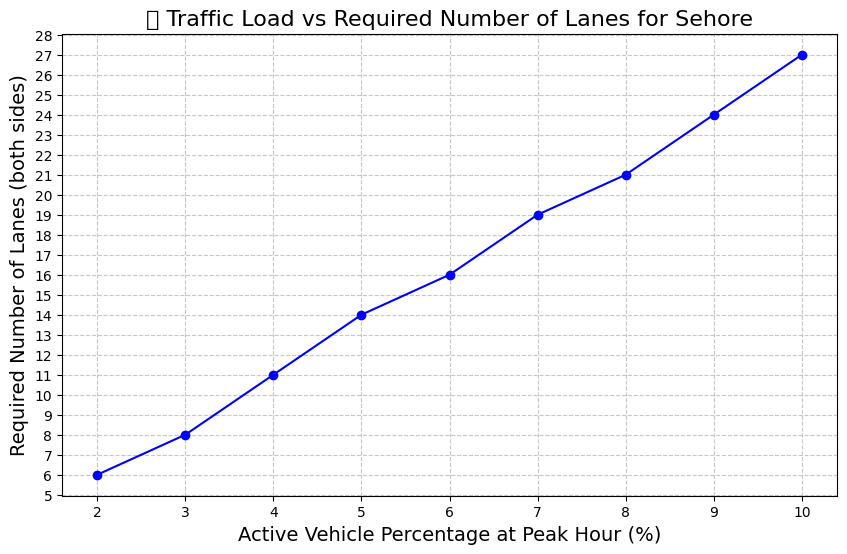

In [ ]:
import math
import matplotlib.pyplot as plt

def calculate_required_lanes(
    population,
    vehicle_ownership_rate=0.2,   # default 20% people have vehicles
    active_percentage=0.05,       # default 5% vehicles active at peak
    vehicles_per_lane_per_hour=1000  # default 1000 vehicles can be handled by 1 lane per hour
):
    total_vehicles = population * vehicle_ownership_rate
    active_vehicles = total_vehicles * active_percentage
    required_lanes = active_vehicles / vehicles_per_lane_per_hour

    print(f"📊 Population: {population}")
    print(f"🚗 Estimated Total Vehicles: {int(total_vehicles)}")
    print(f"🚦 Estimated Active Vehicles (during peak hour): {int(active_vehicles)}")
    print(f"🛣️ Required Lanes (both sides total): {required_lanes:.2f}")

    return required_lanes


# Example: Sehore
sehore_population = 1311008

# Calculate
required_lanes_sehore = calculate_required_lanes(sehore_population)
required_lanes_rounded = math.ceil(required_lanes_sehore)
print(f"\n✅ Final Recommendation: {required_lanes_rounded} lanes total (e.g., {required_lanes_rounded//2} lanes each side)")

# ----- Now let's create the graph! -----

# Traffic scenarios: Vary active percentage from 2% to 10%
active_percentages = [i/100 for i in range(2, 11)]  # 2%, 3%, ..., 10%
required_lanes_list = []

for active_pct in active_percentages:
    lanes = calculate_required_lanes(
        sehore_population,
        vehicle_ownership_rate=0.2,
        active_percentage=active_pct,
        vehicles_per_lane_per_hour=1000
    )
    required_lanes_list.append(math.ceil(lanes))

# Plotting
plt.figure(figsize=(10,6))
plt.plot([p*100 for p in active_percentages], required_lanes_list, marker='o', linestyle='-', color='blue')

plt.title('📈 Traffic Load vs Required Number of Lanes for Sehore', fontsize=16)
plt.xlabel('Active Vehicle Percentage at Peak Hour (%)', fontsize=14)
plt.ylabel('Required Number of Lanes (both sides)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(2, 11))
plt.yticks(range(min(required_lanes_list)-1, max(required_lanes_list)+2))
plt.show()
